In [1]:
!pip install ipynb
!pip install nbimporter
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_curve, auc
import seaborn as sns
import plotly.express as px
sns.set(palette='rainbow', context='talk')
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel, FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.algorithms.state_fidelities import ComputeUncompute


In [2]:
%run EDA.ipynb

Note: you may need to restart the kernel to use updated packages.


# IRIS DATASET

In [3]:
df_, x ,y = irisData ()

## Apply OCC-SVM

In [4]:
target = 'target'
print("The dataset selected has shape: " + str(df_.shape) + " and for each class "+ str(Counter(df_[target])))

The dataset selected has shape: (150, 5) and for each class Counter({0: 50, 1: 50, 2: 50})


### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [5]:
df = df_.copy()
class_label = target

#Select the class you want to be outlier
out_class = 1
outliers_samples = df[df.target == out_class]

outliers_samples = outliers_samples.sample(frac = 0.3)

#concat in out
in_class = 0
inlier_samples = df[df.target == in_class]

# Concatenate the modified outliers samples with the original inlier samples
y = pd.concat([inlier_samples.target, outliers_samples.target], ignore_index=False).sort_index()
x = pd.concat([inlier_samples.drop(columns=class_label), outliers_samples.drop(columns=class_label)], ignore_index=False).sort_index()

Counter(y)

Counter({0: 50, 1: 15})

### Now we proceed with the OCC-SVM

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2468)
n_dim = x.shape[1]
print(n_dim,X_train.shape, y_train.shape, X_test.shape, y_test.shape)

4 (52, 4) (52,) (13, 4) (13,)


In [7]:
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the minority class and {sorted(Counter(y_train).items())[1][1]} records for the majority class.")

The number of records in the training dataset is 52
The number of records in the test dataset is 13
The training dataset has 39 records for the minority class and 13 records for the majority class.


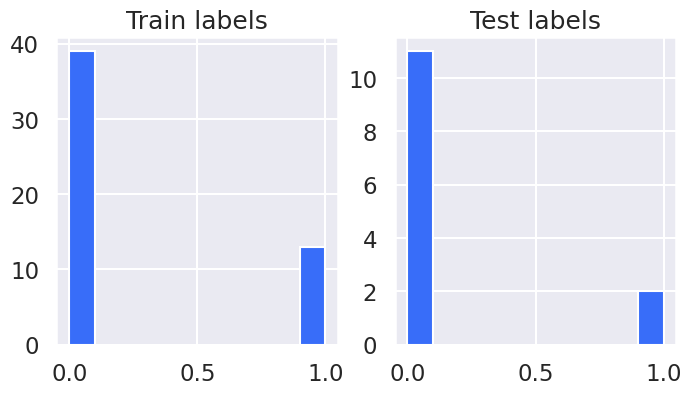

In [8]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

### Quantum kernel

In [9]:
num_qubits = n_dim
zz_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))
zz_circuit = zz_kernel.construct_circuit(X_train.iloc[0], X_train.iloc[1])
# zz_circuit.decompose().decompose().draw(output='mpl')

#### Using Quantum Kernel

In [10]:
from qiskit.circuit.random import random_circuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
start_time = time.time()

options = Options()
options.optimization_level = 2
options.resilience_level = 0

service = QiskitRuntimeService()
with Session(service=service, backend="ibmq_qasm_simulator") as session:
    #num_qubits = len(Counter(y))
    zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement='linear', insert_barriers=True)
    zz_kernel = QuantumKernel(feature_map=zz_map,quantum_instance=Aer.get_backend("qasm_simulator"))
    zz_circuit = zz_kernel.construct_circuit(X_train.iloc[0],X_train.iloc[1])
    
    sampler = Sampler(session=session, options=options)
    job = sampler.run(zz_circuit)
    result = job.result()
    
#display(circuit.draw("mpl"))
#print(f" > Quasi probability distribution: {result.quasi_dists[0]}")
print(f" > Metadata: {result.metadata[0]}")
print("Execution time: ", time.time() - start_time)

 > Metadata: {'shots': 4000}
Execution time:  5.7302281856536865


In [11]:
start_time = time.time()
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(X_train, y_train)
zzcb_score = zzcb_svc.score(X_test, y_test)
prediction = zzcb_svc.predict(X_test)
    
print(f'Callable kernel classification test score: {zzcb_score}')
print("Execution time: ", time.time() - start_time)

Callable kernel classification test score: 0.9230769230769231
Execution time:  12.910452127456665


#### Using Fidelity Quantum Kernel

In [12]:
"""from qiskit.circuit.random import random_circuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
start_time = time.time()

options = Options()
options.optimization_level = 2
options.resilience_level = 0

service = QiskitRuntimeService()
with Session(service=service, backend="ibmq_qasm_simulator") as session:
    
    sampler = Sampler(session=session, options=options)
    zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement='linear', insert_barriers=True)
    fidelity = ComputeUncompute(sampler=sampler)
    zz_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=zz_map)      
   
print("Execution time: ", time.time() - start_time)"""

'from qiskit.circuit.random import random_circuit\nfrom qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options\nstart_time = time.time()\n\noptions = Options()\noptions.optimization_level = 2\noptions.resilience_level = 0\n\nservice = QiskitRuntimeService()\nwith Session(service=service, backend="ibmq_qasm_simulator") as session:\n    \n    sampler = Sampler(session=session, options=options)\n    zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement=\'linear\', insert_barriers=True)\n    fidelity = ComputeUncompute(sampler=sampler)\n    zz_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=zz_map)      \n   \nprint("Execution time: ", time.time() - start_time)'

In [13]:
"""start_time = time.time()
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(X_train, y_train)
zzcb_score = zzcb_svc.score(X_test, y_test)
prediction = zzcb_svc.predict(X_test)
    
print(f'Callable kernel classification test score: {zzcb_score}')
print("Execution time: ", time.time() - start_time)"""

'start_time = time.time()\nzzcb_svc = SVC(kernel=zz_kernel.evaluate)\nzzcb_svc.fit(X_train, y_train)\nzzcb_score = zzcb_svc.score(X_test, y_test)\nprediction = zzcb_svc.predict(X_test)\n    \nprint(f\'Callable kernel classification test score: {zzcb_score}\')\nprint("Execution time: ", time.time() - start_time)'

### Evaluation

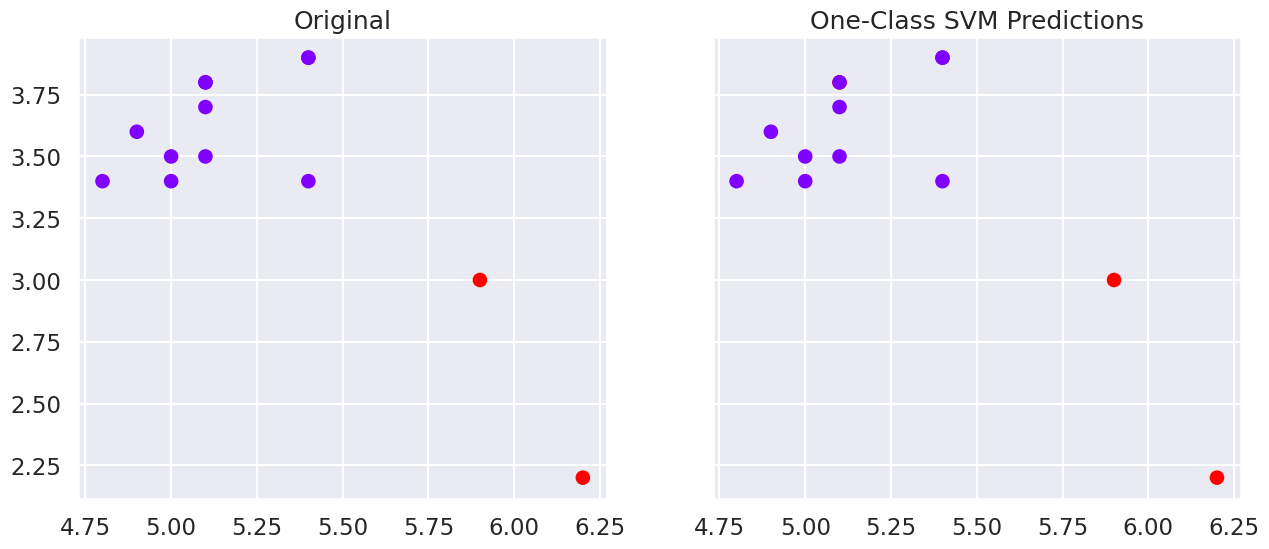

In [14]:
# Put the testing dataset and predictions in the same dataframe
X_test_ = X_test.copy()
y_test_ = y_test.copy()
df_test = pd.DataFrame(X_test_)
df_test['y_test'] = y_test_
df_test['one_class_svm_prediction'] = prediction
# Visualize the actual and predicted anomalies
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(15,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test[0], df_test[1], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test[0], df_test[1], c=df_test['one_class_svm_prediction'], cmap='rainbow')
plt.savefig('scatterplot_IRIS_QSVM.png')

### Evaluation Metrics

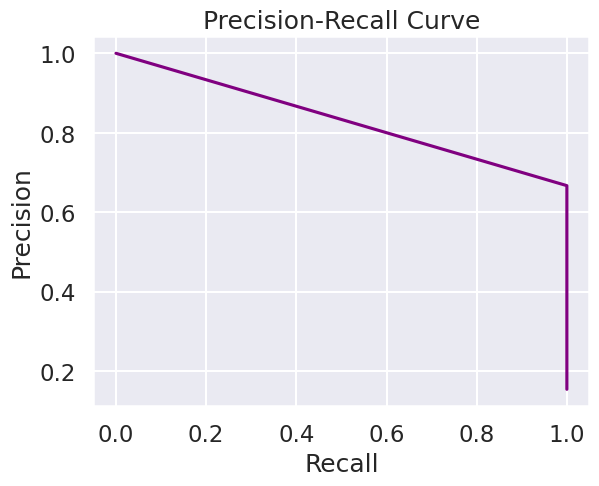

In [15]:
preds = prediction
labels = y_test
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, preds)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
#plt.show()
plt.savefig('precisionCurve_IRIS_QSVM.png')

### ROC-curve

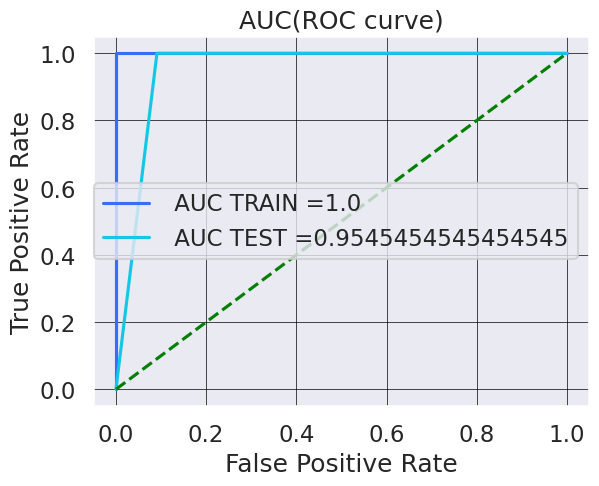

In [16]:
train_prediction = zzcb_svc.predict(X_train)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, train_prediction)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
#plt.show()
plt.savefig('ROCCurve_IRIS_QSVM.png')

# VOWEL DATASET

In [17]:
df_, x ,y = vowelData()

## Apply OCC-SVM

In [18]:
#for vowels dataset
target = 'feature12'

print("The dataset selected has shape: " + str(df_.shape) + " and for each class "+ str(Counter(df_[target])))

The dataset selected has shape: (990, 13) and for each class Counter({0: 90, 1: 90, 2: 90, 3: 90, 4: 90, 5: 90, 6: 90, 7: 90, 8: 90, 9: 90, 10: 90})


### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [19]:
df = df_.copy()

#Select the class you want to be outlier
out_class = 1
outliers_samples = df[df.feature12 == out_class]

outliers_samples = outliers_samples.sample(frac = 0.5)

#concat in out
in_class = 0
inlier_samples = df[df.feature12 == in_class]

# Concatenate the modified outliers samples with the original inlier samples
y = pd.concat([inlier_samples.feature12, outliers_samples.feature12], ignore_index=False).sort_index()
x = pd.concat([inlier_samples.drop(columns='feature12'), outliers_samples.drop(columns='feature12')], ignore_index=False).sort_index()

Counter(y)

Counter({0: 90, 1: 45})

### Now we proceed with the OCC-SVM

In [20]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2468)
n_dim = x.shape[1]
print(n_dim,X_train.shape, y_train.shape, X_test.shape, y_test.shape)

12 (94, 12) (94,) (41, 12) (41,)


In [21]:
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the minority class and {sorted(Counter(y_train).items())[1][1]} records for the majority class.")

The number of records in the training dataset is 94
The number of records in the test dataset is 41
The training dataset has 62 records for the minority class and 32 records for the majority class.


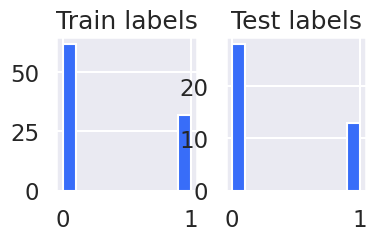

In [22]:
fig, ax = plt.subplots(1,2, figsize=(4,2))

ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

### Quantum Kernel

In [23]:
num_qubits = n_dim
zz_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))
zz_circuit = zz_kernel.construct_circuit(X_train.iloc[0], X_train.iloc[1])
# zz_circuit.decompose().decompose().draw(output='mpl')

#### Using Quantum Kernel

In [24]:
from qiskit.circuit.random import random_circuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
start_time = time.time()

options = Options()
options.optimization_level = 2
options.resilience_level = 0

service = QiskitRuntimeService()
with Session(service=service, backend="ibmq_qasm_simulator") as session:
    #num_qubits = len(Counter(y))
    zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement='linear', insert_barriers=True)
    zz_kernel = QuantumKernel(feature_map=zz_map,quantum_instance=Aer.get_backend("qasm_simulator"))
    zz_circuit = zz_kernel.construct_circuit(X_train.iloc[0], X_train.iloc[1])
    
    sampler = Sampler(session=session, options=options)
    job = sampler.run(zz_circuit)
    result = job.result()
    
#display(circuit.draw("mpl"))
#print(f" > Quasi probability distribution: {result.quasi_dists[0]}")
print(f" > Metadata: {result.metadata[0]}")
print("Execution time: ", time.time() - start_time)

 > Metadata: {'shots': 4000}
Execution time:  17.05739688873291


In [25]:
start_time = time.time()
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(X_train, y_train)
zzcb_score = zzcb_svc.score(X_test, y_test)
prediction = zzcb_svc.predict(X_test)
    
print(f'Callable kernel classification test score: {zzcb_score}')
print("Execution time: ", time.time() - start_time)

Callable kernel classification test score: 0.7317073170731707
Execution time:  183.36274647712708


#### Using Fidelity Quantum Kernel

In [26]:
"""from qiskit.circuit.random import random_circuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
start_time = time.time()

options = Options()
options.optimization_level = 2
options.resilience_level = 0

service = QiskitRuntimeService()
with Session(service=service, backend="ibmq_qasm_simulator") as session:
    
    sampler = Sampler(session=session, options=options)
    zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement='linear', insert_barriers=True)
    fidelity = ComputeUncompute(sampler=sampler)
    zz_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=zz_map)      
   
print("Execution time: ", time.time() - start_time)"""

'from qiskit.circuit.random import random_circuit\nfrom qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options\nstart_time = time.time()\n\noptions = Options()\noptions.optimization_level = 2\noptions.resilience_level = 0\n\nservice = QiskitRuntimeService()\nwith Session(service=service, backend="ibmq_qasm_simulator") as session:\n    \n    sampler = Sampler(session=session, options=options)\n    zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement=\'linear\', insert_barriers=True)\n    fidelity = ComputeUncompute(sampler=sampler)\n    zz_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=zz_map)      \n   \nprint("Execution time: ", time.time() - start_time)'

In [27]:
"""start_time = time.time()
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(X_train, y_train)
zzcb_score = zzcb_svc.score(X_test, y_test)
prediction = zzcb_svc.predict(X_test)
    
print(f'Callable kernel classification test score: {zzcb_score}')
print("Execution time: ", time.time() - start_time)"""

'start_time = time.time()\nzzcb_svc = SVC(kernel=zz_kernel.evaluate)\nzzcb_svc.fit(X_train, y_train)\nzzcb_score = zzcb_svc.score(X_test, y_test)\nprediction = zzcb_svc.predict(X_test)\n    \nprint(f\'Callable kernel classification test score: {zzcb_score}\')\nprint("Execution time: ", time.time() - start_time)'

### Once we find the best performing kernal

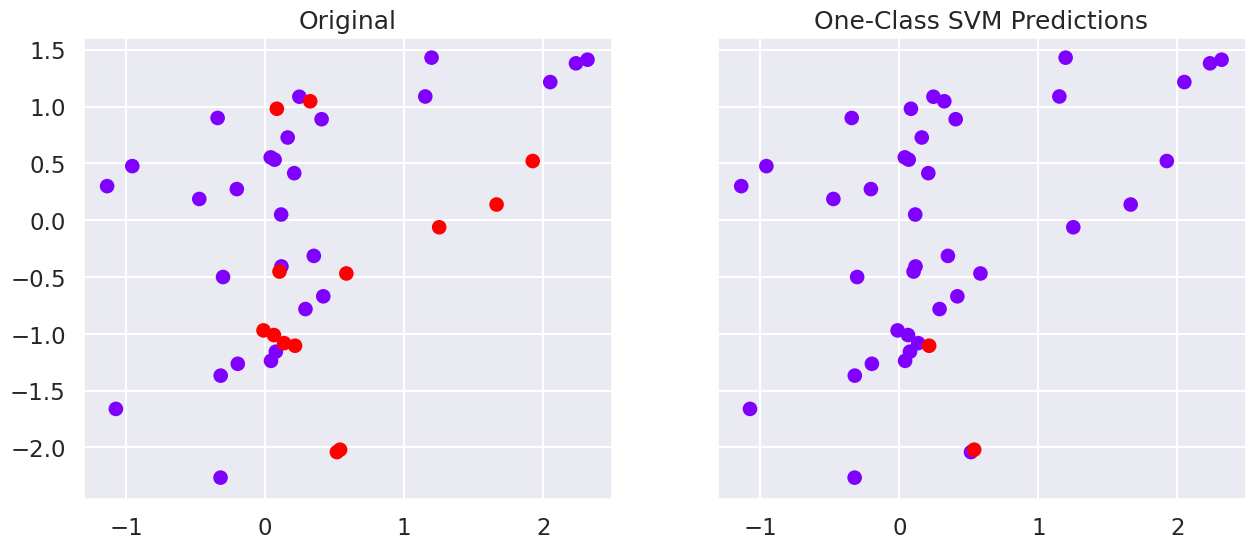

In [28]:
# Put the testing dataset and predictions in the same dataframe
X_test_ = X_test.copy()
y_test_ = y_test.copy()
df_test = pd.DataFrame(X_test_)
df_test['y_test'] = y_test_
df_test['one_class_svm_prediction'] = prediction
# Visualize the actual and predicted anomalies
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(15,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature3'], df_test['feature4'], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature3'], df_test['feature4'], c=df_test['one_class_svm_prediction'], cmap='rainbow')
plt.savefig('ScatterPlot_VOWEL_QSVM.png')

### Evaluation Metrics

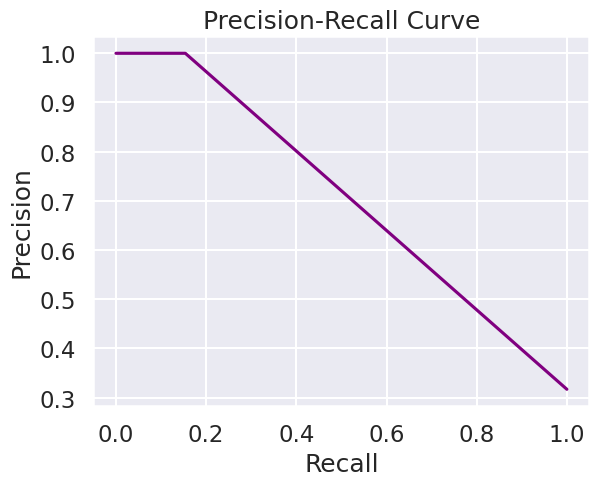

In [29]:
preds = prediction
labels = y_test_
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test_, preds)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
#plt.show()
plt.savefig('PrecisionCurve_VOWEL_QSVM.png')

### ROC-curve

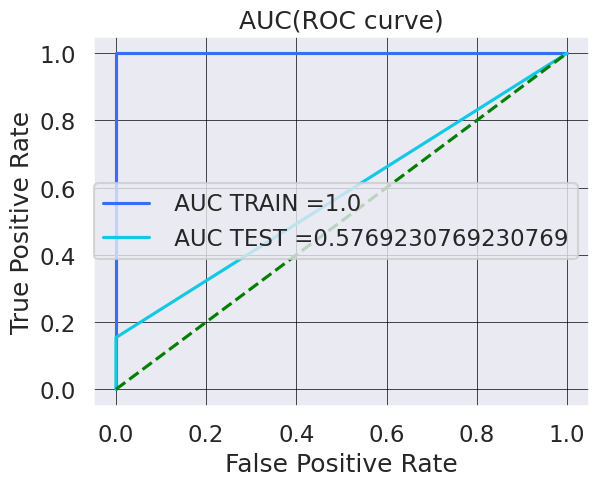

In [30]:
train_prediction = zzcb_svc.predict(X_train)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, train_prediction)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_, preds)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
#plt.show()
plt.savefig('RocCurve_VOWEL_QSVM.png')

# BREAST CANCER DATASET

In [31]:
df_, x ,y = breastcancerData()

## Apply OCC-SVM

In [32]:
target = 'target'

print("The dataset selected has shape: " + str(df_.shape) + " and for each class "+ str(Counter(df_[target])))

The dataset selected has shape: (569, 31) and for each class Counter({1: 357, 0: 212})


### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [33]:
df = df_.copy()
class_label = target

#Select the class you want to be outlier
out_class = 0
outliers_samples = df[df.target == out_class]

outliers_samples = outliers_samples.sample(frac = 0.4)

#concat in out
in_class = 1
inlier_samples = df[df.target == in_class]

# Concatenate the modified outliers samples with the original inlier samples
y = pd.concat([inlier_samples.target, outliers_samples.target], ignore_index=False).sort_index()
x = pd.concat([inlier_samples.drop(columns=class_label), outliers_samples.drop(columns=class_label)], ignore_index=False).sort_index()

Counter(y)

Counter({0: 85, 1: 357})

### Now we proceed with the OCC-SVM

In [34]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2468)

In [35]:
# Reduce dimensions (the dataset now has a dimensionality of 31 attributes)
n_dim = 12 #number of qubits we want to use
pca = PCA(n_components=n_dim).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [36]:
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the minority class and {sorted(Counter(y_train).items())[1][1]} records for the majority class.")

The number of records in the training dataset is 353
The number of records in the test dataset is 89
The training dataset has 62 records for the minority class and 291 records for the majority class.


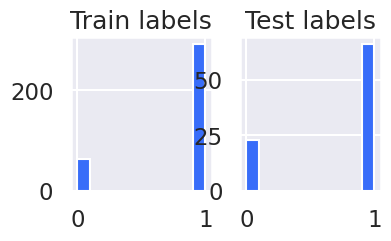

In [37]:
fig, ax = plt.subplots(1,2, figsize=(4,2))

ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

### Quantum Kernel

In [38]:
num_qubits = n_dim
zz_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))
zz_circuit = zz_kernel.construct_circuit(X_train[0], X_train[1])
# zz_circuit.decompose().decompose().draw(output='mpl')

#### Using Quantum Kernel

In [39]:
from qiskit.circuit.random import random_circuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
start_time = time.time()

options = Options()
options.optimization_level = 2
options.resilience_level = 0

service = QiskitRuntimeService()
with Session(service=service, backend="ibmq_qasm_simulator") as session:
    #num_qubits = len(Counter(y))
    zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement='linear', insert_barriers=True)
    zz_kernel = QuantumKernel(feature_map=zz_map,quantum_instance=Aer.get_backend("qasm_simulator"))
    zz_circuit = zz_kernel.construct_circuit(X_train[0], X_train[1])
    
    sampler = Sampler(session=session, options=options)
    job = sampler.run(zz_circuit)
    result = job.result()
    
#display(circuit.draw("mpl"))
#print(f" > Quasi probability distribution: {result.quasi_dists[0]}")
print(f" > Metadata: {result.metadata[0]}")
print("Execution time: ", time.time() - start_time)

 > Metadata: {'shots': 4000}
Execution time:  8.804489135742188


In [40]:
start_time = time.time()
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(X_train, y_train)
zzcb_score = zzcb_svc.score(X_test, y_test)
prediction = zzcb_svc.predict(X_test)
    
print(f'Callable kernel classification test score: {zzcb_score}')
print("Execution time: ", time.time() - start_time)

Callable kernel classification test score: 0.7415730337078652
Execution time:  1896.984870672226


#### Using Fidelity Quantum Kernel

In [41]:
"""from qiskit.circuit.random import random_circuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
start_time = time.time()

options = Options()
options.optimization_level = 2
options.resilience_level = 0

service = QiskitRuntimeService()
with Session(service=service, backend="ibmq_qasm_simulator") as session:
    
    sampler = Sampler(session=session, options=options)
    zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement='linear', insert_barriers=True)
    fidelity = ComputeUncompute(sampler=sampler)
    zz_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=zz_map)      
   
print("Execution time: ", time.time() - start_time)"""

'from qiskit.circuit.random import random_circuit\nfrom qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options\nstart_time = time.time()\n\noptions = Options()\noptions.optimization_level = 2\noptions.resilience_level = 0\n\nservice = QiskitRuntimeService()\nwith Session(service=service, backend="ibmq_qasm_simulator") as session:\n    \n    sampler = Sampler(session=session, options=options)\n    zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement=\'linear\', insert_barriers=True)\n    fidelity = ComputeUncompute(sampler=sampler)\n    zz_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=zz_map)      \n   \nprint("Execution time: ", time.time() - start_time)'

In [42]:
"""start_time = time.time()
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(X_train, y_train)
zzcb_score = zzcb_svc.score(X_test, y_test)
prediction = zzcb_svc.predict(X_test)
    
print(f'Callable kernel classification test score: {zzcb_score}')
print("Execution time: ", time.time() - start_time)"""

'start_time = time.time()\nzzcb_svc = SVC(kernel=zz_kernel.evaluate)\nzzcb_svc.fit(X_train, y_train)\nzzcb_score = zzcb_svc.score(X_test, y_test)\nprediction = zzcb_svc.predict(X_test)\n    \nprint(f\'Callable kernel classification test score: {zzcb_score}\')\nprint("Execution time: ", time.time() - start_time)'

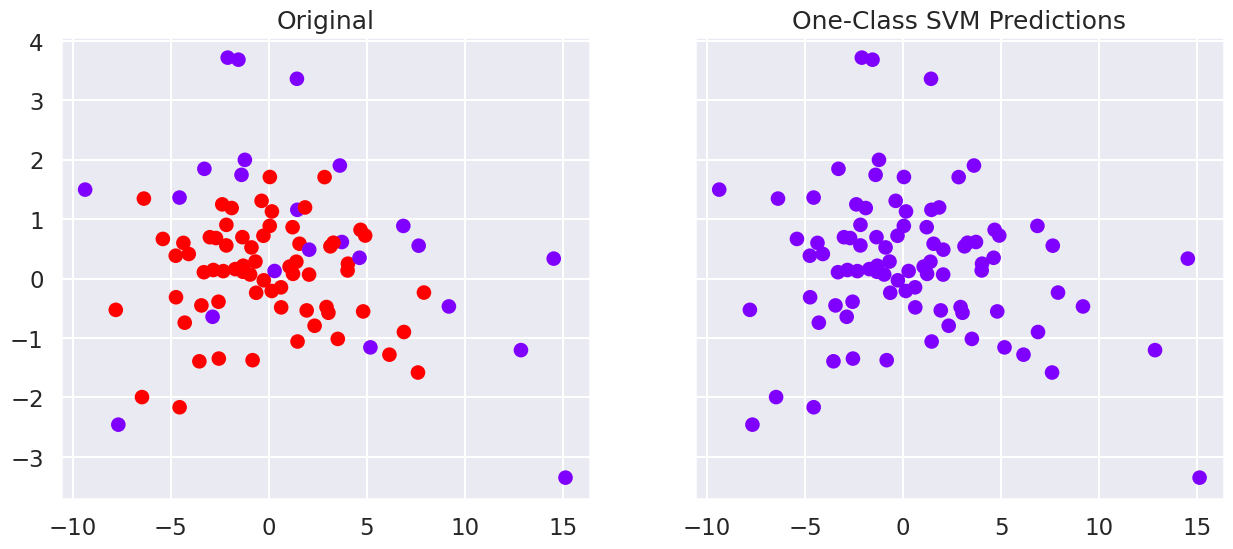

In [43]:
# Put the testing dataset and predictions in the same dataframe
X_test_ = X_test.copy()
y_test_ = y_test.copy()
df_test = pd.DataFrame(X_test_)
df_test['y_test'] = np.array(y_test_)
df_test['one_class_svm_prediction'] = prediction
# Visualize the actual and predicted anomalies
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(15,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test[4], df_test[5], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test[4], df_test[5], c=df_test['one_class_svm_prediction'], cmap='rainbow')
plt.savefig('Scatterplot_BREAST_QSVM.png')

### Evaluation Metrics

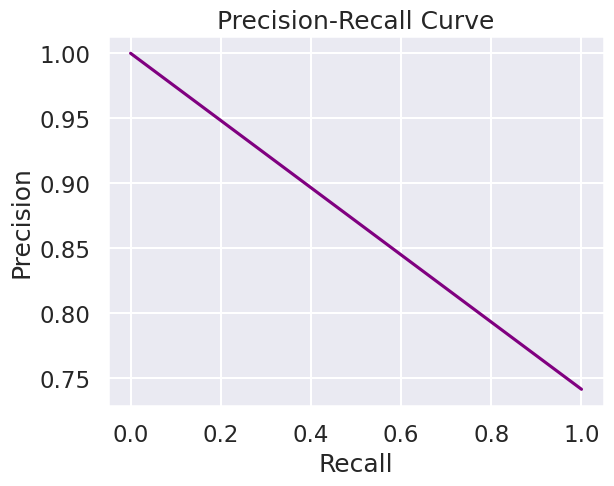

In [44]:
preds = prediction
labels = y_test_
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, preds)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
#plt.show()
plt.savefig('PrecisionCurve_BREAST_QSVM.png')

### ROC-curve

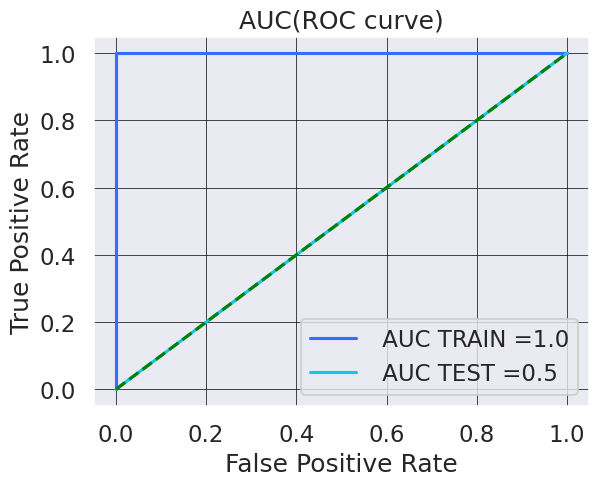

In [45]:
train_prediction = zzcb_svc.predict(X_train)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, train_prediction)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
#plt.show()
plt.savefig('ROCCurve_BREAST_QSVM.png')